In [1]:
!pip install --quiet torchvision

# System utilities
import os
import time
import zipfile

# Numerical processing and image handling
import numpy as np
import cv2

# PyTorch and related modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Computer vision with TorchVision
import torchvision
from torchvision import models, transforms, datasets
import torchvision.transforms as T

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, f1_score

from scipy.stats import spearmanr
import torch.nn.functional as F

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [3]:
## Loading the data

!pip install kaggle
!kaggle datasets download -d anasmohammedtahir/covidqu
with zipfile.ZipFile('covidqu.zip', 'r') as zip_ref:11/dis
    zip_ref.extractall('covidqu')

Dataset URL: https://www.kaggle.com/datasets/anasmohammedtahir/covidqu
License(s): CC-BY-SA-4.0
covidqu.zip: Skipping, found more recently modified local copy (use --force to force download)


In [16]:
## Class to generate datasets

class InfectionBinaryDataset(Dataset):
    def __init__(self, rootpath, mode='Train', cropsize=(224,224)):
        """
        Args:
            rootpath (str): Chemin vers le dossier racine du dataset (ex: "/content/covidqu")
            mode (str): "Train", "Val" ou "Test"
            cropsize (tuple): taille de redimensionnement des images, ici (224,224)
        """
        self.rootpath = rootpath
        self.mode = mode  # "Train", "Val" ou "Test"
        self.cropsize = cropsize
        self.split_dir = os.path.join(self.rootpath,
                                      "Infection Segmentation Data",
                                      "Infection Segmentation Data",
                                      self.mode)

        self.classes_to_use = ["COVID-19", "Normal"]
        self.label_map = {"COVID-19": 1, "Normal": 0}


        self.samples = []
        for cls in self.classes_to_use:
            cls_img_dir = os.path.join(self.split_dir, cls, "images")
            infection_mask_dir = os.path.join(self.split_dir, cls, "infection masks")
            lung_mask_dir = os.path.join(self.split_dir, cls, "lung masks")
            if not os.path.isdir(cls_img_dir):
                continue

            img_files = sorted([f for f in os.listdir(cls_img_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])

            for img in img_files:
                #self.samples.append((os.path.join(cls_img_dir, img), self.label_map[cls]))
                img_path = os.path.join(cls_img_dir, img)
                infection_mask_path = os.path.join(infection_mask_dir, img)
                lung_mask_path = os.path.join(lung_mask_dir, img)

                # Check if all necessary files exist before adding them
                if os.path.exists(infection_mask_path) and os.path.exists(lung_mask_path):
                    self.samples.append((img_path, infection_mask_path, lung_mask_path, self.label_map[cls]))

        # Here we make sure we shuffle the order of the images
        import random
        random.shuffle(self.samples)

        # Transformation
        self.transform = T.Compose([
            T.ToPILImage(),
            T.Resize(self.cropsize),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, infection_mask_path, lung_mask_path, label = self.samples[idx]

        # Load image
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform(img)  # Apply transformations

        # Load infection mask
        infection_mask = cv2.imread(infection_mask_path, cv2.IMREAD_GRAYSCALE)
        if infection_mask is None:
            raise FileNotFoundError(f"Infection mask not found: {infection_mask_path}")
        infection_mask = cv2.cvtColor(infection_mask, cv2.COLOR_BGR2RGB)
        infection_mask = self.transform(infection_mask)

        # Load lung mask
        lung_mask = cv2.imread(lung_mask_path, cv2.IMREAD_GRAYSCALE)
        if lung_mask is None:
            raise FileNotFoundError(f"Lung mask not found: {lung_mask_path}")
        lung_mask = cv2.cvtColor(lung_mask, cv2.COLOR_BGR2RGB)
        lung_mask = self.transform(lung_mask)

        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)

        return img, infection_mask, lung_mask, label


In [5]:
## Instancing the class to create datasets and dataloaders

dataset_root = "/content/covidqu"

data_train = InfectionBinaryDataset(rootpath=dataset_root, mode="Train", cropsize=(224,224))
data_val   = InfectionBinaryDataset(rootpath=dataset_root, mode="Val",   cropsize=(224,224))
data_test  = InfectionBinaryDataset(rootpath=dataset_root, mode="Test",  cropsize=(224,224))

batch_size = 64

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(data_val,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(data_test,  batch_size=batch_size, shuffle=False)

In [7]:
from google.colab import files
uploaded = files.upload()


Saving vit_explain_modulable.py to vit_explain_modulable (3).py
Saving vit_explain.py to vit_explain (3).py
Saving vit_explainability.py to vit_explainability (3).py
Saving vit_grad_rollout.py to vit_grad_rollout (3).py
Saving vit_LRPexact.py to vit_LRPexact (3).py
Saving vit_LRPmimic.py to vit_LRPmimic (3).py
Saving vit_rollout.py to vit_rollout (3).py


In [8]:
from google.colab import files
uploaded = files.upload()


Saving deit_tiny_head_weights.pth to deit_tiny_head_weights (3).pth


In [10]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
import os
folder_path = "/content/drive/My Drive/Transformer_Explainability"
os.listdir(folder_path)  # Liste des fichiers


['README.md',
 'new_work.jpg',
 'LICENSE',
 'example.PNG',
 'Transformer_explainability.ipynb',
 'DeiT.PNG',
 'requirements.txt',
 'example.ipynb',
 'method-page-001.jpg',
 'DeiT_example.ipynb',
 'modules',
 'dataset',
 'baselines',
 'samples',
 'data',
 'utils']

In [10]:
import sys
sys.path.append("/content/drive/My Drive")

In [17]:
import os
import glob
import cv2
import json
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from types import SimpleNamespace
from vit_explain_modulable import run_explanation, load_model, show_mask_on_image

def create_composite(original_img, results_dict):
    orig = np.array(original_img)  # in RGB
    orig = cv2.cvtColor(orig, cv2.COLOR_RGB2BGR)
    orig = cv2.resize(orig, (224, 224))
    composite_images = [orig]
    for method, mask in results_dict.items():
        m = cv2.resize(mask, (orig.shape[1], orig.shape[0]))
        overlay = show_mask_on_image(orig, m)
        cv2.putText(overlay, method, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        composite_images.append(overlay)
    comp = np.hstack(composite_images)
    return comp

#define the methods we evaluate
#methods = ["attention", "gradient", "explainability", "transformer_attribution", "full_LRP","partial_LRP"]
methods = ["attention", "gradient", "transformer_attribution", "full_LRP","partial_LRP"]

# Parameters for the model, as a dictionary
model_parameters = {"pretrained": True, "weights_path": "deit_tiny_head_weights.pth"}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformation for the input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Create a dummy args dictionary
args_dict = {
    "category_index": None,
    "discard_ratio": 0.9,
    "head_fusion": "mean",
    "attention_layer_name": "attn_drop",
    "model_name": "deit_tiny_finetuned",
    "use_cuda": True,
}

args = SimpleNamespace(**args_dict)

# Load the finetuned model
model = load_model(args.model_name, model_parameters)
model = model.to(device)
model.eval()

# ## Here we test the main imported functions
# Loop over a subset of images from the dataset and generate composite images.

# Get list of images from dataset directory (adjust extension if necessary)
#dataset_dir = "/content/covidqu"
output_dir = "comparisons"
os.makedirs(output_dir, exist_ok=True)
#image_files = glob.glob(os.path.join(dataset_dir, "*.[jp][pn]g"))
image_files = [data_test[0]]

print(f"Found {len(image_files)} images.")

# Process only a few images for demonstration
for data in image_files:
    print("Processing")
    img, infection_mask, lung_mask, label = data  # Unpack the tuple

    image_pil = transforms.ToPILImage()(img)

    input_tensor = transform(image_pil).unsqueeze(0).to(device)

    results = {}
    for method in methods:
        try:
            mask, _ = run_explanation(method, model, input_tensor, args)
            results[method] = torch.tensor(mask, dtype=img.dtype, device=img.device)
        except Exception as e:
            print(f"Method {method} failed on: {e}")

        print(model(input_tensor).argmax().item(), method, mask.sum())

deit_tiny_finetuned
Found 1 images.
Processing
Doing Attention Rollout
1 attention 18.379187
Doing Gradient Attention Rollout
1 gradient 10.733716
Doing transformer attribution Method
Vit_explanation_generator, index is  [1]
1 transformer_attribution 5359.0786
Doing LRP exact Method
Vit_explanation_generator, index is  [1]
1 full_LRP 2022.5852
Doing partial LRP
Vit_explanation_generator, index is  [1]
1 partial_LRP 3423.6755


In [18]:
def faithfulness_correlation(data, model, method, args=None, removal_ratio=0.1):
    """
    Compute the faithfulness correlation between the model's prediction and the heatmap.
    We cover the most meaningful zones of the image, and return the shift of probabilities between the original and perturbed images.
    """
    img, infection_mask, lung_mask, label = data

    input_tensor = transform(transforms.ToPILImage()(img)).unsqueeze(0).to(device)

    mask, _ = run_explanation(method, model, input_tensor, args=args)
    mask = cv2.resize(mask, (14, 14), interpolation=cv2.INTER_NEAREST) #we create 14*14 patches of the image, to be removed
    mask = torch.tensor(mask)
    num_pixels_to_remove = int(mask.numel() * removal_ratio) # Compute number of pixels to remove
    threshold = torch.topk(mask.view(-1), num_pixels_to_remove, largest=True).values[-1]  # Get the lowest value in the top-K

    # Create a perturbed image: Set top pixels to black (0)
    perturbed_input = input_tensor.clone()
    mask_binary = (mask >= threshold).float().to(device)  # 1 where pixels should be removed, 0 elsewhere
    mask_binary = mask_binary.unsqueeze(0).unsqueeze(0)
    mask_binary = F.interpolate(mask_binary, (224,224), mode='nearest')
    perturbed_input *= (1 - mask_binary)
    perturbed_res = model(perturbed_input)
    original_res = model(input_tensor)
    original_prob = F.softmax(original_res, dim=-1)  # Probabilities from original logits
    perturbed_prob = F.softmax(perturbed_res, dim=-1)  # Probabilities from perturbed logits

    # Compute KL Divergence
    #kl_div = F.kl_div(original_prob.log(), perturbed_prob, reduction='batchmean')

    # Compute shift of probabilities
    return original_prob[0][label.item()].item() - perturbed_prob[0][label.item()].item()

In [20]:
removal_ratios = [0.04, 0.08, 0.12, 0.16, 0.2]
dataset = [data_test[0], data_test[1], data_test[2]]

methods_scores = {method: [] for method in methods}
for method in methods:
    scores = []
    for ratio in removal_ratios:
        score = 0
        for data in dataset:
            s = faithfulness_correlation(data, model, method, args=args, removal_ratio=ratio)
            score += s
        score /= len(dataset)
        scores.append(score)
    methods_scores[method] = scores

Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing transformer attribution Method
Vit_explanation_generator, index is  [1]
Doing transformer attribution Method
Vit_explanation_generator, ind

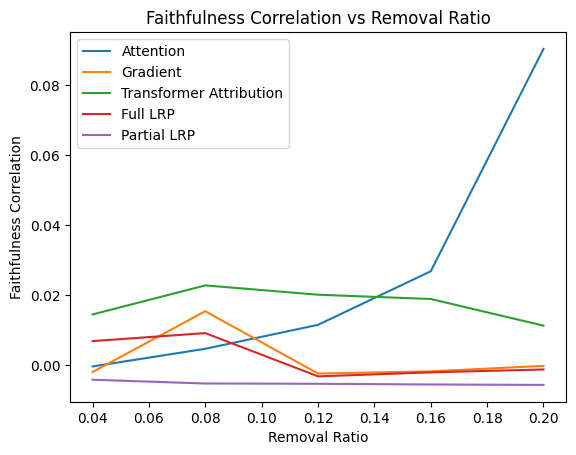

In [21]:
plt.plot(removal_ratios, methods_scores['attention'], label='Attention')
plt.plot(removal_ratios, methods_scores['gradient'], label='Gradient')
plt.plot(removal_ratios, methods_scores['transformer_attribution'], label='Transformer Attribution')
plt.plot(removal_ratios, methods_scores['full_LRP'], label='Full LRP')
plt.plot(removal_ratios, methods_scores['partial_LRP'], label='Partial LRP')
plt.xlabel('Removal Ratio')
plt.ylabel('Faithfulness Correlation')
plt.title('Faithfulness Correlation vs Removal Ratio')
plt.legend()
plt.show()

In [19]:
def average_sensitivity(data, model, method, args=None, num_perturbations=3, epsilon=0.02):
    """
    Compute the average sensitivity of explanations under small perturbations.
    We evaluate the evolution of the heatmaps under small gaussian noise.
    """

    img, infection_mask, lung_mask, label = data  # Unpack the tuple

    input_tensor = transform(transforms.ToPILImage()(img)).unsqueeze(0).to(device)

    # Compute the original explanation heatmap
    mask_original, _ = run_explanation(method, model, input_tensor, args=args)

    sensitivity_scores = []

    for _ in range(num_perturbations):
        # Generate random noise
        noise = torch.randn_like(img) * epsilon  # Small Gaussian noise

        # Apply perturbation ONLY in the lung_mask region
        perturbed_img = img + noise * lung_mask  # Noise is only added where lung_mask is white
        perturbed_input_tensor = transform(transforms.ToPILImage()(perturbed_img)).unsqueeze(0).to(device)

        # Compute the perturbed explanation heatmap
        mask_perturbed, _ = run_explanation(method, model, perturbed_input_tensor, args=args)

        # Compute sensitivity as the mean absolute difference between the original and perturbed heatmaps
        sensitivity = torch.abs(torch.tensor(mask_original - mask_perturbed)).mean().item()
        sensitivity_scores.append(sensitivity)

    # Compute the average sensitivity over perturbations
    avg_sensitivity = sum(sensitivity_scores) / num_perturbations

    return avg_sensitivity

In [14]:
epsilons = [0.01, 0.05, 0.1]
dataset = [data_test[0], data_test[1], data_test[2]]

methods_scores = {method: [] for method in methods}
for method in methods:
    scores = []
    for eps in epsilons:
        score = 0
        for data in dataset:
            s = average_sensitivity(data, model, method, args=args, num_perturbations=2, epsilon=eps)
            score += s
        score /= len(dataset)
        scores.append(score)
    methods_scores[method] = scores

Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attenti

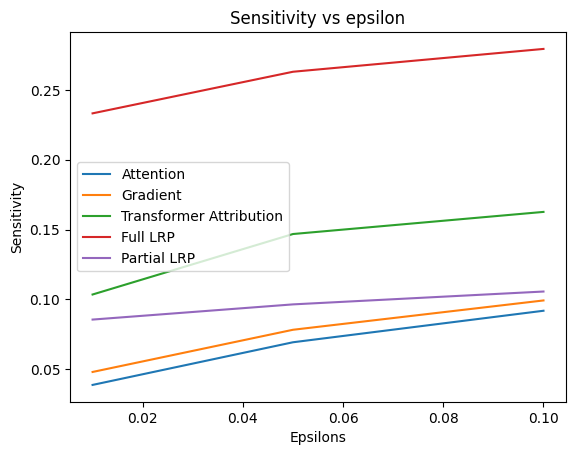

In [15]:
plt.plot(epsilons, methods_scores['attention'], label='Attention')
plt.plot(epsilons, methods_scores['gradient'], label='Gradient')
plt.plot(epsilons, methods_scores['transformer_attribution'], label='Transformer Attribution')
plt.plot(epsilons, methods_scores['full_LRP'], label='Full LRP')
plt.plot(epsilons, methods_scores['partial_LRP'], label='Partial LRP')
plt.xlabel('Epsilons')
plt.ylabel('Sensitivity')
plt.title('Sensitivity vs epsilon')
plt.legend()
plt.show()

In [13]:
def effective_complexity(data, model, methode, args, threshold = 0.5):
    """
    Compute effective complexity by counting the number of pixels in the heatmap above a threshold.
    """
    img, infection_mask, lung_mask, label = data  # Unpack the tuple

    input_tensor = transform(transforms.ToPILImage()(img)).unsqueeze(0).to(device)

    mask, _ = run_explanation(method, model, input_tensor, args=args)

    binary_maps = (mask > threshold)

    complexity_scores = binary_maps.mean()

    return complexity_scores


In [14]:
thresholds = [0.1, 0.15, 0.2, 0.3, 0.4, 0.7]
dataset = [data_test[0], data_test[1], data_test[2], data_test[3]]

methods_scores = {method: [] for method in methods}
for method in methods:
    scores = []
    for t in thresholds:
        score = 0
        for data in dataset:
            s = effective_complexity(data, model, method, args=args, threshold=t)
            score += s
        score /= len(dataset)
        scores.append(score)
    methods_scores[method] = scores

Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rollout
Doing Gradient Attention Rol

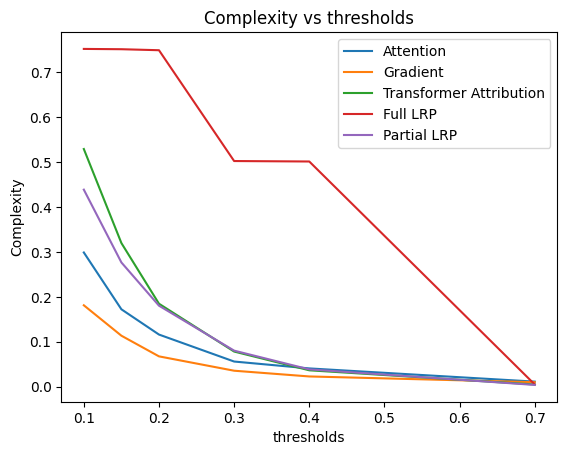

In [15]:
plt.plot(thresholds, methods_scores['attention'], label='Attention')
plt.plot(thresholds, methods_scores['gradient'], label='Gradient')
plt.plot(thresholds, methods_scores['transformer_attribution'], label='Transformer Attribution')
plt.plot(thresholds, methods_scores['full_LRP'], label='Full LRP')
plt.plot(thresholds, methods_scores['partial_LRP'], label='Partial LRP')
plt.xlabel('thresholds')
plt.ylabel('Complexity')
plt.title('Complexity vs thresholds')
plt.legend()
plt.show()